# Set-up

In [1]:
# Importo las librerías necesarias.
import os
import gc
import torch
import torchaudio
import tarfile
import IPython
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as td
import torchaudio.transforms as tt
from torchaudio.datasets import GTZAN
import matplotlib
import matplotlib.pyplot as plt
from google.colab import drive

# Setear en False en caso de no querer entrenar (requiere utilizar los pesos entregados).
TRAIN_NETWORK = True

In [2]:
# Utilizo GPU de estar disponible.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Seteo una semilla para replicabilidad.
SEED = 42
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

cuda:0


# Encodear en vectores latentes

## Lectura del dataset (GTZAN)

In [3]:
# Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos
drive.mount('/content/drive')
data_dir = '//content/drive/MyDrive/UTDT/TD6/genres_5sec/' # Para el correcto funcionamiento, editar segun donde se encuentre el dataset en su drive.
list_files = os.listdir(data_dir)

# Obtenemos las clases (géneros)
classes=[]
for file in list_files:
  name='{}/{}'.format(data_dir,file)
  if os.path.isdir(name):
    classes.append(file)

# Funciones auxiliares para la clase del dataset
samplerate=22050

# Para obtener generos
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

# Para definir transformación de audios
def transform(audio):
    return tt.Spectrogram()(audio)

# Definimos clase para obtener el dataset
class MusicDataset():
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.files =[]
        for c in classes:
          self.files = self.files + [fname for fname in os.listdir(os.path.join(root,c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))
        self.transform = tt.Spectrogram()

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        genre = parse_genres(fname)
        fpath = os.path.join(self.root,genre, fname)
        class_idx = self.classes.index(genre)
        audio = torchaudio.load(fpath)[0]
        spectrogram = self.transform(audio)

        return audio, spectrogram, class_idx

dataset = MusicDataset(data_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Hiperparámetros

In [4]:
# Hiperparámetros
batch_size = 20
learning_rate = 0.02
epochs = 40

## División de training, validation y testing

In [5]:
# Divido en training, validation, testing.
val_size = 100
test_size = 100
train_size = len(dataset) - val_size - test_size

generator = torch.Generator().manual_seed(SEED)
train_ds, val_ds, test_ds = td.random_split(dataset, [train_size, val_size, test_size], generator)

train_dl = td.DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = td.DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_dl = td.DataLoader(test_ds,1, num_workers=2, pin_memory=True)

## Elección del modelo a correr

In [6]:
# Elegir entre "55k", "32k", "24k", "18k", "9k"
latent_size = "18k"

## Definición de channels, kernel size, stride, padding, según modelo elegido

In [7]:
if latent_size == "55k":
  exact_latent_size = "55112"
  ic1, ic2, ic3 = 4, 6, 8
  ks1, ks2, ks3 = 10, 5, 3
  s1, s2, s3 = 4, 2, 2
  p1, p2, p3 = 0, 0, 0
  unflatten_tuple = (8, 6889)

if latent_size == "32k":
  exact_latent_size = "32151"
  ic1, ic2, ic3 = 3, 6, 7
  ks1, ks2, ks3 = 6, 4, 3
  s1, s2, s3 = 4, 3, 2
  p1, p2, p3 = 0, 0, 0
  unflatten_tuple = (7, 4593)

if latent_size == "24k":
  exact_latent_size = "24496"
  ic1, ic2, ic3 = 4, 6, 8
  ks1, ks2, ks3 = 12, 5, 2
  s1, s2, s3 = 6, 3, 2
  p1, p2, p3 = 0, 0, 0
  unflatten_tuple = (8, 3062)

if latent_size == "18k":
  exact_latent_size = "18376"
  ic1, ic2, ic3 = 10, 6, 8
  ks1, ks2, ks3 = 20, 5, 1
  s1, s2, s3 = 12, 2, 2
  p1, p2, p3 = 1, 1, 0
  unflatten_tuple = (8, 2297)

if latent_size == "9k":
  exact_latent_size = "9184"
  ic1, ic2, ic3 = 4, 4, 4
  ks1, ks2, ks3 = 6, 4, 4
  s1, s2, s3 = 4, 6, 2
  p1, p2, p3 = 0, 0, 0
  unflatten_tuple = (4, 2296)

## Definicion de encoder, decoder y autoencoder con los parámetros elegidos

In [8]:
# Definición del encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, ic1, kernel_size=ks1, stride=s1, padding=p1),
            nn.Tanh(),
            nn.Conv1d(ic1, ic2, kernel_size=ks2, stride=s2, padding=p2),
            nn.Tanh(),
            nn.Conv1d(ic2, ic3, kernel_size=ks3, stride=s3, padding=p3),
            nn.Tanh(),
        )
        self.latent_space = nn.Flatten()

    def forward(self, x):
        x = self.encoder(x)
        latent_rep = self.latent_space(x)
        return latent_rep

# Definición del decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.unflatten = nn.Unflatten(1, unflatten_tuple)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(ic3, ic2, kernel_size=ks3, stride=s3, padding=p3),
            nn.Tanh(),
            nn.ConvTranspose1d(ic2, ic1, kernel_size=ks2, stride=s2, padding=p2),
            nn.Tanh(),
            nn.ConvTranspose1d(ic1, 1, kernel_size=ks1, stride=s1, padding=p1),
        )

    def forward(self, x):
        x = self.unflatten(x)
        reconstructed_seq = self.decoder(x)
        return reconstructed_seq

# Definición del Convolutional Autoencoder (CAE)
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_rep = self.encoder(x)
        reconstructed_seq = self.decoder(latent_rep)
        return reconstructed_seq, latent_rep

## Inicialización del modelo

In [9]:
# Definición del modelo
model = CAE()
model.to(device)
print(model)

CAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv1d(1, 10, kernel_size=(20,), stride=(12,), padding=(1,))
      (1): Tanh()
      (2): Conv1d(10, 6, kernel_size=(5,), stride=(2,), padding=(1,))
      (3): Tanh()
      (4): Conv1d(6, 8, kernel_size=(1,), stride=(2,))
      (5): Tanh()
    )
    (latent_space): Flatten(start_dim=1, end_dim=-1)
  )
  (decoder): Decoder(
    (unflatten): Unflatten(dim=1, unflattened_size=(8, 2297))
    (decoder): Sequential(
      (0): ConvTranspose1d(8, 6, kernel_size=(1,), stride=(2,))
      (1): Tanh()
      (2): ConvTranspose1d(6, 10, kernel_size=(5,), stride=(2,), padding=(1,))
      (3): Tanh()
      (4): ConvTranspose1d(10, 1, kernel_size=(20,), stride=(12,), padding=(1,))
    )
  )
)


## Definición de función de pérdida RMSE

In [10]:
# https://discuss.pytorch.org/t/rmse-loss-function/16540/4
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

## Definición del optimizador y entrenamiento

In [11]:
if TRAIN_NETWORK:
  # Definición de función de perdida
  criterion = RMSELoss()

  # Definición del optimizador
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  # Importante para ir liberando memoria ram
  torch.cuda.empty_cache()
  gc.collect()

  lowest_loss = 1000
  best_epoch = -1

  for epoch in range(epochs):
      train_losses = []
      # Entrenamiento
      model.train()
      for batch in train_dl:
          optimizer.zero_grad()  # Clear gradients

          inputs, _, _ = batch
          inputs = inputs.to(device)
          # Forward pass
          outputs, _ = model(inputs)

          # Compute reconstruction loss
          loss = criterion(outputs, inputs)

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          train_losses.append(loss.item())

          # Importante para ir liberando memoria ram
          del inputs
          del loss
          del outputs
          torch.cuda.empty_cache()
          gc.collect()

      # Validation
      model.eval()
      val_losses = []
      with torch.no_grad():
          for batch in valid_dl:
              inputs, _, _ = batch
              inputs = inputs.to(device)
              outputs, _ = model(inputs)
              loss = criterion(outputs, inputs)
              val_losses.append(loss.item())

      # Importante para ir liberando memoria ram
      del inputs
      del loss
      del outputs
      torch.cuda.empty_cache()
      gc.collect()

      # Para estadisticas de wandb
      if val_losses[-1] < lowest_loss:
          lowest_loss = val_losses[-1]
          best_epoch = epoch
          best_model_state_dict = model.state_dict()

      # Print progress
      print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {np.mean(train_losses):.4f}, Validation Loss: {np.mean(val_losses):.4f}')

  # Indico por consola cuando finalizó el entrenamiento
  print(f"Entrenamiento finalizado, la loss más baja fue {str(lowest_loss)} la mejor epoch:{str(best_epoch)}")

  # Guardo el modelo entrenado en disco
  PATH = f'./cae_{latent_size}.pth'
  torch.save(best_model_state_dict, PATH)

Epoch [1/40], Training Loss: 0.1061, Validation Loss: 0.0849
Epoch [2/40], Training Loss: 0.0758, Validation Loss: 0.0723
Epoch [3/40], Training Loss: 0.0694, Validation Loss: 0.0722
Epoch [4/40], Training Loss: 0.0689, Validation Loss: 0.0692
Epoch [5/40], Training Loss: 0.0681, Validation Loss: 0.0693
Epoch [6/40], Training Loss: 0.0654, Validation Loss: 0.0707
Epoch [7/40], Training Loss: 0.0649, Validation Loss: 0.0660
Epoch [8/40], Training Loss: 0.0636, Validation Loss: 0.0699
Epoch [9/40], Training Loss: 0.0641, Validation Loss: 0.0654
Epoch [10/40], Training Loss: 0.0635, Validation Loss: 0.0636
Epoch [11/40], Training Loss: 0.0631, Validation Loss: 0.0643
Epoch [12/40], Training Loss: 0.0600, Validation Loss: 0.0597
Epoch [13/40], Training Loss: 0.0597, Validation Loss: 0.0612
Epoch [14/40], Training Loss: 0.0586, Validation Loss: 0.0658
Epoch [15/40], Training Loss: 0.0594, Validation Loss: 0.0606
Epoch [16/40], Training Loss: 0.0594, Validation Loss: 0.0594
Epoch [17/40], Tr

## Carga del modelo

In [12]:
# Load the best model
S = torch.load(f'cae_{latent_size}.pth')
model.load_state_dict(S)

<All keys matched successfully>

## Forward del autoencoder en el dataset

In [13]:
model.eval()

reconstructed_audios_list = []
latent_vector_list = []
for audio, _, _ in test_dl:

    audio = audio.to(device)

    with torch.no_grad():
        # Forward pass
        reconstructed_output, latent_vec = model(audio)
        # Save the reconstructed output to the list
        reconstructed_audios_list.append(reconstructed_output.squeeze(0).cpu())
        # Save the latent vector to the list
        latent_vector_list.append(latent_vec.cpu())

## Selección de una canción para probar el modelo

In [14]:
wav, spec, label = test_dl.dataset[15]
reconstructed_audio = reconstructed_audios_list[15]

## Exportamos los vectores latentes como numpy para la notebook de análisis

In [15]:
concatenated_array = np.concatenate([tensor.numpy() for tensor in latent_vector_list], axis=0)
np.save(f'latent_vector_{exact_latent_size}.npy', concatenated_array)

## Audio, espectograma y waveform del original

In [16]:
# Audio original
IPython.display.Audio(wav, rate=22050)

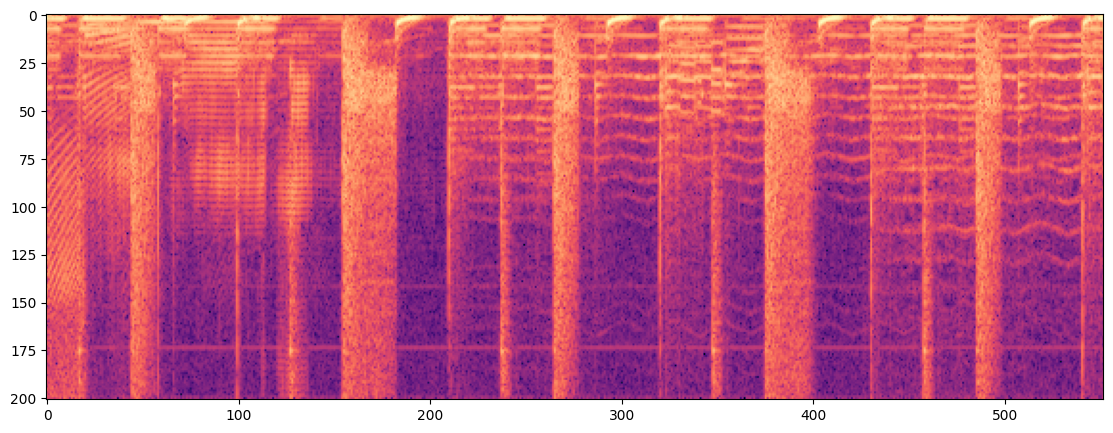

In [17]:
# Espectograma original
plt.figure(figsize=(20, 5))
plt.imshow(spec.log2()[0,:,:].numpy(),cmap='magma')

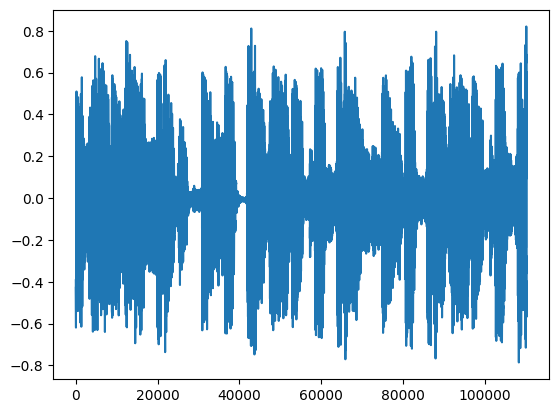

In [18]:
# Waveform original
plt.figure()
plt.plot(wav.t().numpy())

## Audio, espectograma y waveform del reconstruido

In [19]:
# Audio reconstruido
IPython.display.Audio(reconstructed_audio, rate=22050)

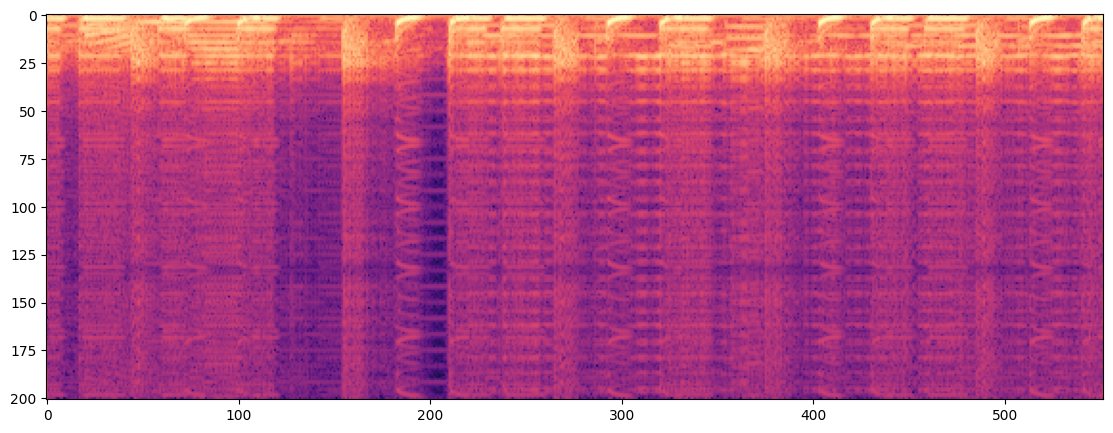

In [20]:
# Espectograma reconstruido
reconstructed_spec = transform(reconstructed_audio)
plt.figure(figsize=(20, 5))
plt.imshow(reconstructed_spec.log2()[0,:,:].numpy(),cmap='magma')

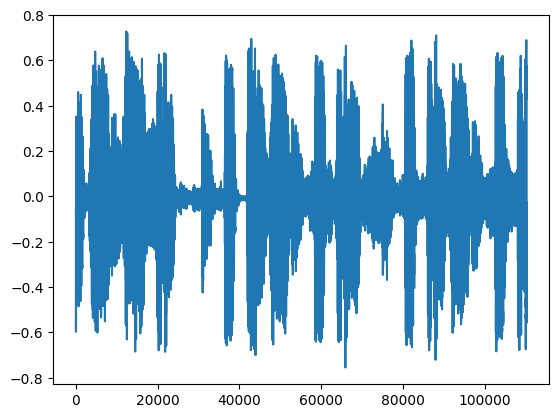

In [21]:
# Waveform reconstruido
plt.figure()
plt.plot(reconstructed_audio.t().numpy())

# Uso de la red para encodear música externa al dataset

## Nueva carga de archivos

In [22]:
new_music_dir = '//content/drive/MyDrive/UTDT/TD6/new_music_chopped/' # Para el correcto funcionamiento, editar segun donde se encuentre el dataset nuevo en su drive.
list_files = os.listdir(new_music_dir)

# Obtenemos las clases (géneros)
classes=[]
for file in list_files:
  name='{}/{}'.format(new_music_dir,file)
  if os.path.isdir(name):
    classes.append(file)

# Funciones auxiliares para la clase del dataset
samplerate=22050

# Para obtener generos
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

# Definimos clase para obtener el dataset
class MusicDataset():
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.files =[]
        for c in classes:
          self.files = self.files + [fname for fname in os.listdir(os.path.join(root,c)) if fname.endswith('.mp3')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))

    def transform(self, audio):
        resampler = tt.Resample(orig_freq=220500, new_freq=110250, dtype=audio.dtype)
        audio = resampler(audio)
        return audio

    def spec(self, audio):
        return tt.Spectrogram()(audio)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        genre = parse_genres(fname)
        fpath = os.path.join(self.root,genre, fname)
        class_idx = self.classes.index(genre)
        audio, sample_rate = torchaudio.load(fpath)
        audio = self.transform(audio)
        spectrogram = self.spec(audio)

        return audio, spectrogram, class_idx

new_music_ds = MusicDataset(new_music_dir)
new_music = td.DataLoader(new_music_ds,1, num_workers=2, pin_memory=True)

## Forward del autoencoder en el nuevo dataset

In [23]:
model.eval()

new_reconstructed_audios_list = []

for audio, _, _ in new_music:
    audio = audio.to(device)
    with torch.no_grad():
        new_reconstructed_output, new_latent_vec = model(audio)
        new_reconstructed_audios_list.append(new_reconstructed_output.squeeze(0).cpu())

## Selección de la canción para probar el modelo

In [24]:
wav, spec, label = new_music.dataset[0]
new_reconstructed_audio = new_reconstructed_audios_list[0]

## Audio, espectograma y waveform del original

In [25]:
# Audio original
IPython.display.Audio(wav, rate=22050)

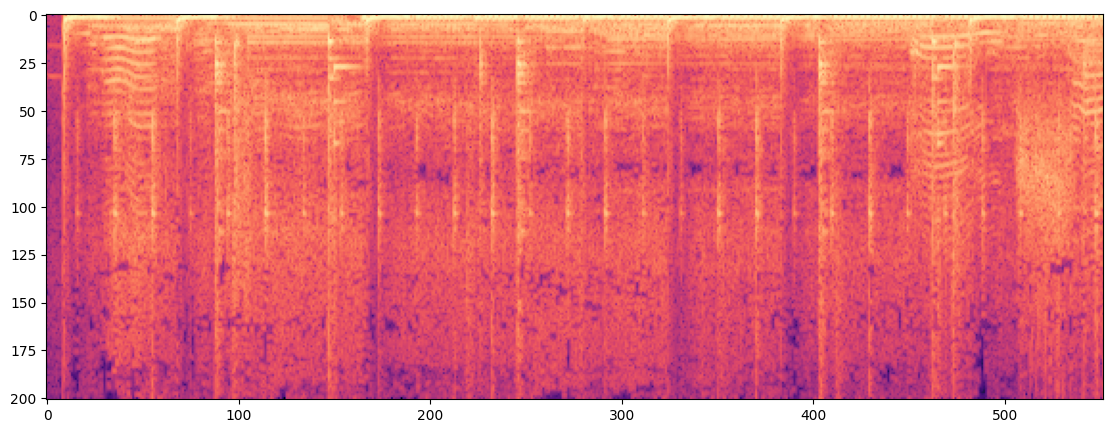

In [26]:
# Espectograma original
plt.figure(figsize=(20, 5))
plt.imshow(spec.log2()[0,:,:].numpy(),cmap='magma')

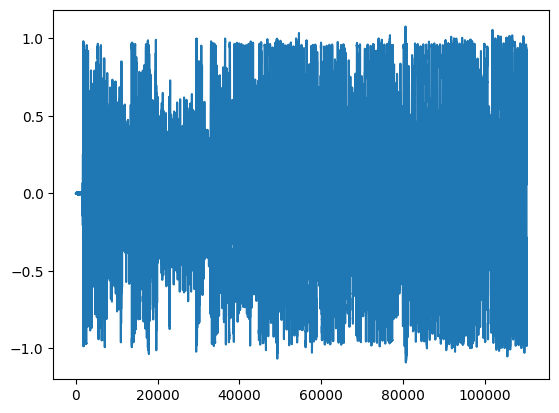

In [27]:
# Waveform original
plt.figure()
plt.plot(wav.t().numpy())

## Audio, espectograma y waveform del reconstruido

In [28]:
# Audio reconstruido
IPython.display.Audio(new_reconstructed_audio, rate=22050)

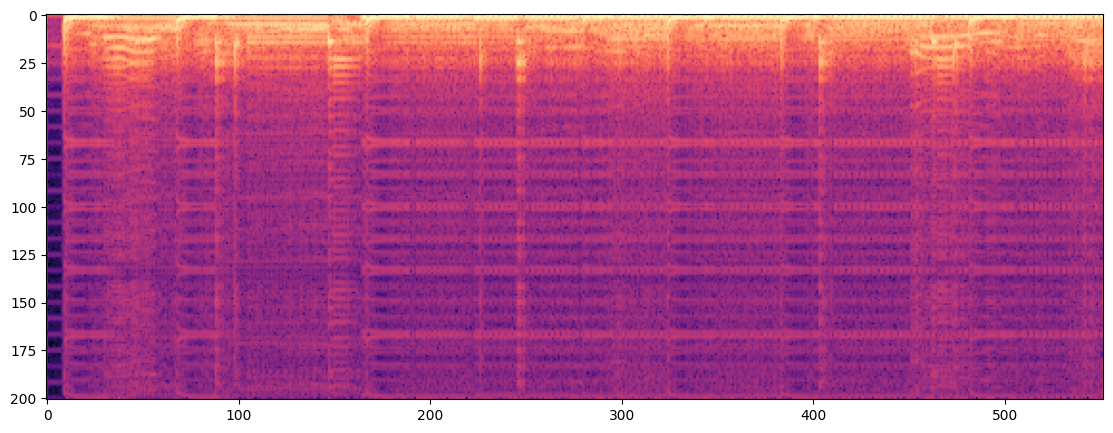

In [29]:
# Espectograma reconstruido
new_reconstructed_spec = tt.Spectrogram()(new_reconstructed_audio)
plt.figure(figsize=(20, 5))
plt.imshow(new_reconstructed_spec.log2()[0,:,:].numpy(),cmap='magma')

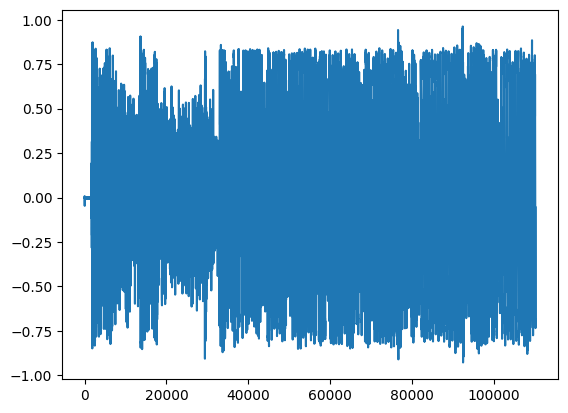

In [30]:
# Waveform reconstruido
plt.figure()
plt.plot(new_reconstructed_audio.t().numpy())

# Creación de nueva música

## Promediando vectores latentes del dataset

In [31]:
# Agarramos los primeros 3 vectores latentes.
song1 = latent_vector_list[1]
song2 = latent_vector_list[2]
song3 = latent_vector_list[3]

# Promediamos
stacked_tensors = np.stack((song1, song2, song3))
mean_tensor = np.mean(stacked_tensors, axis=0)
new_latent_vector = torch.tensor(mean_tensor)

In [32]:
# Move the model to CPU
decoder = model.decoder.cpu()
with torch.no_grad():
    new_audio = decoder(new_latent_vector).squeeze(0)

In [33]:
# Nuevo audio
IPython.display.Audio(new_audio, rate=22050)

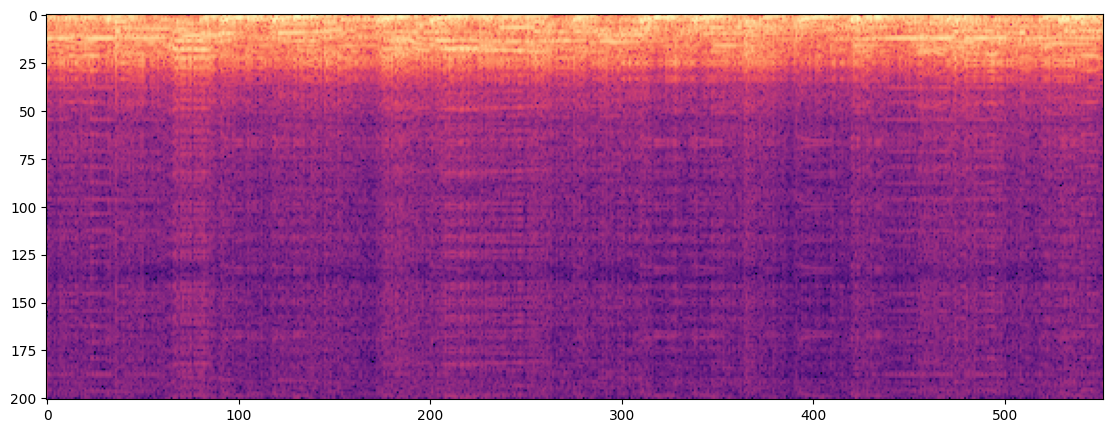

In [34]:
# Espectograma del nuevo audio
new_audio_spec = transform(new_audio)
plt.figure(figsize=(20, 5))
plt.imshow(new_audio_spec.log2()[0,:,:].numpy(),cmap='magma')

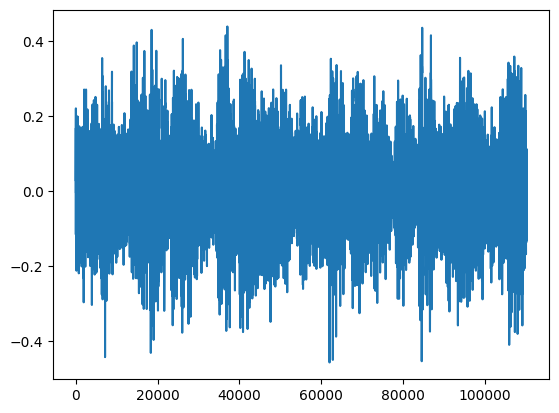

In [35]:
# Waveform del nuevo audio
plt.figure()
plt.plot(new_audio.t().numpy())

## Haciendo un vector aleatorio de la dimensión del vector latente.

In [36]:
random_latent = torch.rand(1, int(exact_latent_size))

In [37]:
with torch.no_grad():
    new_audio = decoder(random_latent).squeeze(0)

In [38]:
# Nuevo audio
IPython.display.Audio(new_audio, rate=22050)

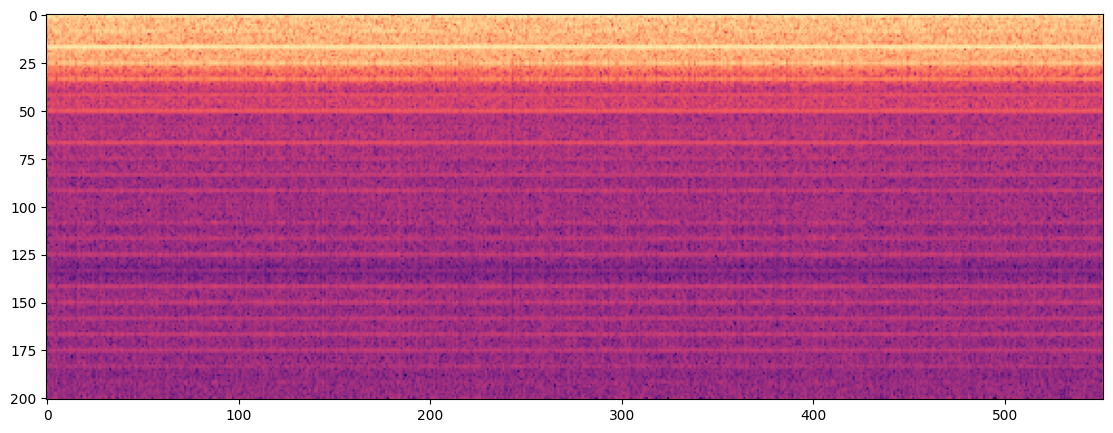

In [39]:
# Espectograma del nuevo audio
new_audio_spec = transform(new_audio)
plt.figure(figsize=(20, 5))
plt.imshow(new_audio_spec.log2()[0,:,:].numpy(),cmap='magma')

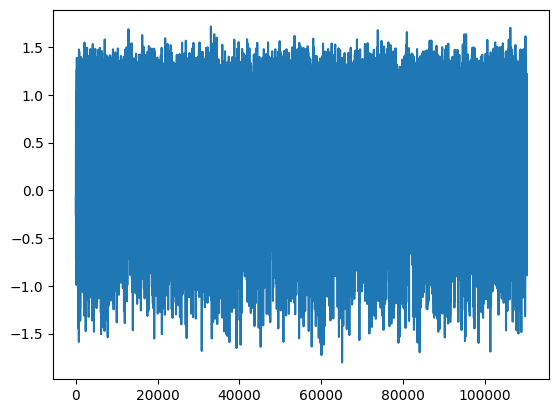

In [40]:
# Waveform del nuevo audio
plt.figure()
plt.plot(new_audio.t().numpy())